# Analisis exploratorio

## Exportacion de librerias

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

In [3]:

current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path

import root 

## Carga de datos

In [4]:
client = pd.read_csv(root.DIR_DATA_RAW + 'client.csv')
electricity_prices = pd.read_csv(root.DIR_DATA_RAW + 'electricity_prices.csv')
gas_prices = pd.read_csv(root.DIR_DATA_RAW + 'gas_prices.csv')
historical_weather = pd.read_csv(root.DIR_DATA_RAW + 'historical_weather.csv')
forecast_weather = pd.read_csv(root.DIR_DATA_RAW + 'forecast_weather.csv')
train = pd.read_csv(root.DIR_DATA_RAW + 'train.csv')


## Train DataSet

In [5]:
print(train.shape)

(2018352, 9)


In [6]:
train.head(2)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0


In [7]:
print("Primer registro:", train['datetime'].min())
print("Último registro:", train['datetime'].max())

Primer registro: 2021-09-01 00:00:00
Último registro: 2023-05-31 23:00:00


### numero de productos y condados

In [8]:
train['county'].nunique()

16

In [9]:
train['product_type'].nunique()

4

In [10]:
train['is_business'].nunique()

2

### conversion a datatime

In [11]:
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d %H:%M:%S')

### division por produccion y consumo

In [12]:
production = train.copy()
production = production[production['is_consumption'] == 0].reset_index(drop=True)
production['row_id'] = production.index

In [13]:
production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009176 entries, 0 to 1009175
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              1009176 non-null  int64         
 1   is_business         1009176 non-null  int64         
 2   product_type        1009176 non-null  int64         
 3   target              1008912 non-null  float64       
 4   is_consumption      1009176 non-null  int64         
 5   datetime            1009176 non-null  datetime64[ns]
 6   data_block_id       1009176 non-null  int64         
 7   row_id              1009176 non-null  int64         
 8   prediction_unit_id  1009176 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 69.3 MB


In [14]:
consumption = train.copy()
consumption = consumption[consumption['is_consumption'] == 1].reset_index(drop=True)
consumption['row_id'] = consumption.index

### conteo de cuantos usuarios reportan al dia

In [15]:
production['changed'] = production['datetime'] != production['datetime'].shift(1)

# Filtrar filas donde hubo cambios
changed_rows = production[production['changed']]

# Imprimir las filas donde cambia el valor de tiempo
changed_rows.head(10)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,changed
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,True
61,0,0,1,1.132,0,2021-09-01 01:00:00,0,61,0,True
122,0,0,1,0.490,0,2021-09-01 02:00:00,0,122,0,True
183,0,0,1,0.496,0,2021-09-01 03:00:00,0,183,0,True
244,0,0,1,0.149,0,2021-09-01 04:00:00,0,244,0,True
305,0,0,1,0.298,0,2021-09-01 05:00:00,0,305,0,True
366,0,0,1,1.271,0,2021-09-01 06:00:00,0,366,0,True
427,0,0,1,22.122,0,2021-09-01 07:00:00,0,427,0,True
488,0,0,1,64.257,0,2021-09-01 08:00:00,0,488,0,True
549,0,0,1,170.312,0,2021-09-01 09:00:00,0,549,0,True


In [16]:
process_df = changed_rows.copy()
process_df['salto']= process_df['row_id'] - process_df['row_id'].shift(1)
process_df['salto'].unique()

array([nan, 61., 63., 65., 66., 67., 68., 69., 64.])

In [17]:
process_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,changed,salto
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,True,NaN
61,0,0,1,1.132,0,2021-09-01 01:00:00,0,61,0,True,61.0
122,0,0,1,0.490,0,2021-09-01 02:00:00,0,122,0,True,61.0
183,0,0,1,0.496,0,2021-09-01 03:00:00,0,183,0,True,61.0
244,0,0,1,0.149,0,2021-09-01 04:00:00,0,244,0,True,61.0


In [18]:
process_df['salto_shift'] = process_df['salto'].shift(1)  # Creamos una columna con el valor anterior de 'salto'

# Filtramos filas donde 'salto' sea diferente al valor anterior o el primer valor
df_filtered = process_df[(process_df['salto'] != process_df['salto_shift']) | (process_df.index == 0)]

# Eliminamos la columna auxiliar
df_filtered = df_filtered.drop(columns=['salto_shift'])

# Mostrar el resultado
df_filtered.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,changed,salto
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,True,NaN
61,0,0,1,1.132,0,2021-09-01 01:00:00,0,61,0,True,61.0
43983,0,0,1,0.043,0,2021-10-01 01:00:00,30,43983,0,True,63.0
183089,0,0,1,0.000,0,2022-01-01 01:00:00,122,183089,0,True,65.0
231450,0,0,1,0.041,0,2022-02-01 01:00:00,153,231450,0,True,66.0


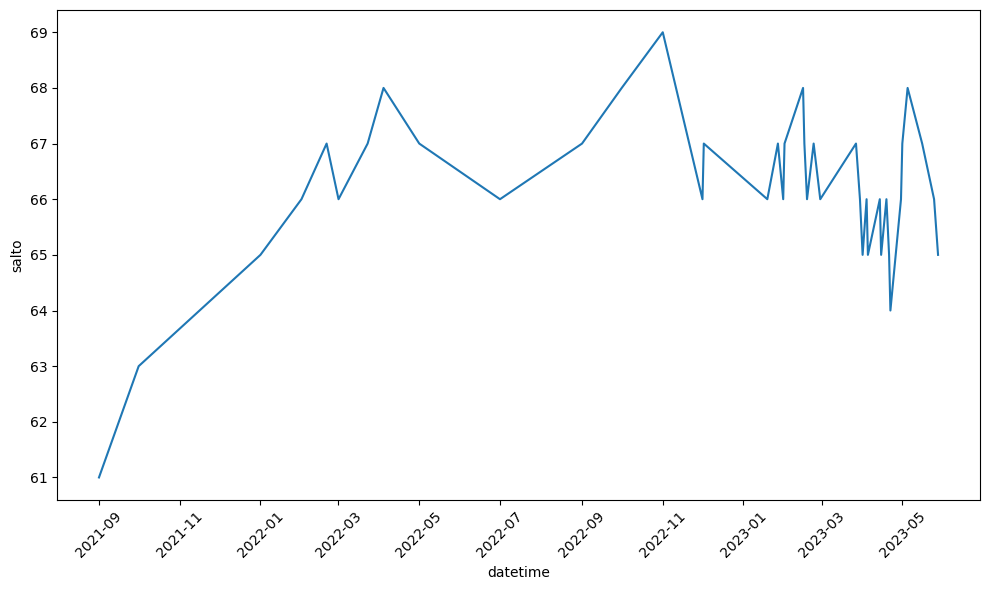

In [19]:
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura
sns.lineplot(x='datetime', y='salto', data=df_filtered)

# Rotar las etiquetas del eje x si hay muchas fechas
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### group by por dia de los reportes de los consumidores

In [22]:
grouped = production.groupby(['data_block_id', 'prediction_unit_id'])['target'].mean().reset_index()


In [23]:
grouped.head(5)

,data_block_id,prediction_unit_id,target
0,0,0,116.543542
1,0,1,24.389667
2,0,2,927.062792
3,0,3,29.775000
4,0,4,67.542792


Cuanto consume en promedio cada tipo usuario por hora en un dia

In [24]:
grouped = production.groupby(['data_block_id', 'prediction_unit_id']).agg({
    'target': 'mean',               # Promedio de 'target'
    'county': 'first',               # Toma el primer valor de 'county'
    'is_business': 'first',          # Toma el primer valor de 'is_business'
    'product_type': 'first',         # Toma el primer valor de 'product_type'
    'is_consumption': 'first',       # Toma el primer valor de 'is_consumption'
    'datetime': 'first',             # Toma el primer valor de 'datetime'
}).reset_index()

In [25]:
grouped.head(10)

,data_block_id,prediction_unit_id,target,county,is_business,product_type,is_consumption,datetime
0,0,0,116.543542,0,0,1,0,2021-09-01
1,0,1,24.389667,0,0,2,0,2021-09-01
2,0,2,927.062792,0,0,3,0,2021-09-01
3,0,3,29.775000,0,1,0,0,2021-09-01
4,0,4,67.542792,0,1,1,0,2021-09-01
5,0,5,772.729500,0,1,3,0,2021-09-01
6,0,6,12.201708,1,0,1,0,2021-09-01
7,0,7,82.754583,1,0,3,0,2021-09-01
8,0,8,43.124583,1,1,3,0,2021-09-01
9,0,9,55.576292,2,0,3,0,2021-09-01


In [29]:
grouped = production.groupby(['product_type', 'county']).agg({
    'target': 'mean',               # Promedio de 'target'
    #'county': 'first',               # Toma el primer valor de 'county'
    'is_business': 'first',          # Toma el primer valor de 'is_business'
    #'product_type': 'first',         # Toma el primer valor de 'product_type'
    'is_consumption': 'first',       # Toma el primer valor de 'is_consumption'
    'datetime': 'first',             # Toma el primer valor de 'datetime'
}).reset_index()

In [31]:
grouped.head(17)

,product_type,county,target,is_business,is_consumption,datetime
0,0,0,31.097303,1,0,2021-09-01
1,0,4,53.161374,1,0,2021-09-01
2,0,5,30.599344,1,0,2021-09-01
3,0,7,62.515787,1,0,2021-09-01
4,0,11,14.440853,1,0,2022-02-01
5,0,15,24.258870,1,0,2021-12-01
6,1,0,153.852529,0,0,2021-09-01
7,1,1,9.842362,0,0,2021-09-01
8,1,2,11.565013,0,0,2021-10-01
9,1,3,19.165467,0,0,2021-09-01
